In [1]:
#Functions
#Extracts Features
def extractFeatures(data, features):
    extracted_df = pd.DataFrame()
    for string in features:
        extracted_df[string] = data[string]
    return extracted_df

#PCA of Data <!> NOT USED
def pca(data, colors):
    pca = PCA(n_components = 2)
    pcs = pca.fit_transform(data)
    pc_df = pd.DataFrame(pcs, columns = ["PC1", "PC2"])
    fig = plt.scatter(pc_df["PC1"], pc_df["PC2"], s = 3, c = colors)
    return fig

#Returns a star rating depending on each listing's total review score
def getStarRating(value):
    star = math.floor(value/20)
    return star

#Prep the cleaned data for the KNN Algorithm (Label Encoding, Standardizing Features, turning all values into numerical)
def prepData(data):
    #Creating prepped data datafram
    prepped = data.copy()
    #Creating label encoding and standard scalar
    le = pp.LabelEncoder()
    sc = pp.StandardScaler()
    for x in categorical_features:
        prepped[x] = le.fit_transform(data[x])
    #Changing percentages and dollar values to floating points
    for x in string_features:
        prepped[x] = prepped[x].map(lambda x: x.lstrip('$').rstrip('%'))
    #Changing amenities to the amount of amenities a listing may have
    prepped['amenities'] = prepped['amenities'].map(lambda x: len(x.split(',')))
    #Changing bathrooms to amount of bathrooms a listing has
    prepped['bathrooms_text'] = prepped['bathrooms_text'].map(lambda x: re.findall("\d+\.\d+|\d+", x+'1')[0])
    #Standardizing features
    prepped['price'] = prepped['price'].map(lambda x: float(x.replace(",",""))) #Converts price to a float
    for x in standardize_features:
        data = prepped[x].values.reshape(-1,1)
        prepped[x] = sc.fit_transform(data)
    return prepped

In [2]:
#Imports
import re
import math
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.preprocessing as pp
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier as KNN

In [3]:
#Creating a list of categorical data to be encoded
categorical_features = ['host_response_time', 'host_is_superhost','property_type','room_type']

#Creating a list of features that are strings but need to change to a numerical type
string_features = ['host_response_rate','host_acceptance_rate','price']

#Features to Standardize
standardize_features = ['host_response_rate','host_acceptance_rate','price', 'beds', 'amenities', 'number_of_reviews']

# DATA EXPLORATION

In [4]:
#Reading the prepped data
amst_prepped = pd.read_csv("Amsterdam_Prepped.csv")
la_prepped = pd.read_csv("LosAngeles_Prepped.csv")
mel_prepped = pd.read_csv("Melbourne_Prepped.csv")

In [5]:
#Dropping "Unnamed: 0" Column (Not sure why its there)
amst_prepped = amst_prepped.drop(amst_prepped.columns[0], axis = 1)
la_prepped = la_prepped.drop(la_prepped.columns[0], axis = 1)
mel_prepped = mel_prepped.drop(mel_prepped.columns[0], axis = 1)

In [6]:
#Converting review_scores_rating to star ratings
amst_star_ratings = amst_prepped["review_scores_rating"].map(lambda x: getStarRating(x))
la_star_ratings = la_prepped["review_scores_rating"].map(lambda x: getStarRating(x))
mel_star_ratings = mel_prepped["review_scores_rating"].map(lambda x: getStarRating(x))

In [7]:
numerical_features = ['host_is_superhost','host_response_rate','host_acceptance_rate','price', 'beds', 'amenities', 'number_of_reviews','review_scores_rating']
amst_numerical = extractFeatures(amst_prepped, numerical_features)
la_numerical = extractFeatures(la_prepped, numerical_features)
mel_numerical = extractFeatures(mel_prepped, numerical_features)

In [25]:
#Covariance Matrix of Amsterdam Data
print(amst_numerical.cov())

                      host_is_superhost  host_response_rate  \
host_is_superhost              0.128403            0.008238   
host_response_rate             0.008238            1.000053   
host_acceptance_rate           0.019600            0.192775   
price                          0.015544           -0.006605   
beds                          -0.001765           -0.026930   
amenities                      0.086256            0.007919   
number_of_reviews              0.134896           -0.020916   
review_scores_rating           0.235594            0.251894   

                      host_acceptance_rate     price      beds  amenities  \
host_is_superhost                 0.019600  0.015544 -0.001765   0.086256   
host_response_rate                0.192775 -0.006605 -0.026930   0.007919   
host_acceptance_rate              1.000053 -0.000779 -0.035556  -0.081911   
price                            -0.000779  1.000053  0.083834   0.026726   
beds                             -0.035556  0.0

In [9]:
#Covariance Matrix of Los Angeles Data
la_numerical.cov()

,host_is_superhost,host_response_rate,host_acceptance_rate,price,beds,amenities,number_of_reviews,review_scores_rating
host_is_superhost,0.217281,0.071732,0.043270,-0.015802,-0.000372,0.143417,0.136703,0.641231
host_response_rate,0.071732,1.000033,0.215446,-0.068321,-0.005617,0.089594,0.072051,0.411291
host_acceptance_rate,0.043270,0.215446,1.000033,-0.129052,-0.037824,0.001348,0.107773,-0.208530
price,-0.015802,-0.068321,-0.129052,1.000033,0.313783,0.070420,-0.065156,0.426368
beds,-0.000372,-0.005617,-0.037824,0.313783,1.000033,0.238864,-0.020487,-0.147456
amenities,0.143417,0.089594,0.001348,0.070420,0.238864,1.000033,0.181740,0.416866
number_of_reviews,0.136703,0.072051,0.107773,-0.065156,-0.020487,0.181740,1.000033,0.046656
review_scores_rating,0.641231,0.411291,-0.208530,0.426368,-0.147456,0.416866,0.046656,70.755045


In [10]:
#Covariance Matrix of Melbourne Data
mel_numerical.cov()

,host_is_superhost,host_response_rate,host_acceptance_rate,price,beds,amenities,number_of_reviews,review_scores_rating
host_is_superhost,0.177846,0.035700,0.032801,-0.002695,0.006450,0.137308,0.152569,0.546851
host_response_rate,0.035700,1.000050,0.099215,-0.003759,-0.018790,0.029513,0.022155,0.675278
host_acceptance_rate,0.032801,0.099215,1.000050,-0.028536,0.010482,0.060110,0.099527,-0.110314
price,-0.002695,-0.003759,-0.028536,1.000050,0.206131,0.047151,-0.024295,0.338210
beds,0.006450,-0.018790,0.010482,0.206131,1.000050,0.244294,0.031967,-0.177316
amenities,0.137308,0.029513,0.060110,0.047151,0.244294,1.000050,0.300411,0.148749
number_of_reviews,0.152569,0.022155,0.099527,-0.024295,0.031967,0.300411,1.000050,0.136059
review_scores_rating,0.546851,0.675278,-0.110314,0.338210,-0.177316,0.148749,0.136059,76.473389


In [11]:
#Correlation Matrix of Amsterdam Data
amst_numerical.corr()

,host_is_superhost,host_response_rate,host_acceptance_rate,price,beds,amenities,number_of_reviews,review_scores_rating
host_is_superhost,1.000000,0.022989,0.054695,0.043378,-0.004926,0.240709,0.376445,0.099488
host_response_rate,0.022989,1.000000,0.192764,-0.006605,-0.026929,0.007919,-0.020915,0.038115
host_acceptance_rate,0.054695,0.192764,1.000000,-0.000779,-0.035554,-0.081907,0.045943,-0.055496
price,0.043378,-0.006605,-0.000779,1.000000,0.083829,0.026724,-0.027666,0.009870
beds,-0.004926,-0.026929,-0.035554,0.083829,1.000000,0.149197,-0.027629,-0.013293
amenities,0.240709,0.007919,-0.081907,0.026724,0.149197,1.000000,0.168595,0.115167
number_of_reviews,0.376445,-0.020915,0.045943,-0.027666,-0.027629,0.168595,1.000000,-0.031959
review_scores_rating,0.099488,0.038115,-0.055496,0.009870,-0.013293,0.115167,-0.031959,1.000000


In [12]:
#Correlation Matrix of Los Angeles Data
la_numerical.corr()

,host_is_superhost,host_response_rate,host_acceptance_rate,price,beds,amenities,number_of_reviews,review_scores_rating
host_is_superhost,1.000000,0.153885,0.092827,-0.033899,-0.000799,0.307667,0.293264,0.163540
host_response_rate,0.153885,1.000000,0.215439,-0.068319,-0.005617,0.089591,0.072049,0.048895
host_acceptance_rate,0.092827,0.215439,1.000000,-0.129048,-0.037823,0.001348,0.107770,-0.024790
price,-0.033899,-0.068319,-0.129048,1.000000,0.313773,0.070417,-0.065154,0.050687
beds,-0.000799,-0.005617,-0.037823,0.313773,1.000000,0.238856,-0.020486,-0.017530
amenities,0.307667,0.089591,0.001348,0.070417,0.238856,1.000000,0.181734,0.049558
number_of_reviews,0.293264,0.072049,0.107770,-0.065154,-0.020486,0.181734,1.000000,0.005547
review_scores_rating,0.163540,0.048895,-0.024790,0.050687,-0.017530,0.049558,0.005547,1.000000


In [13]:
#Correlation Matrix of Melbourne Data
mel_numerical.corr()

,host_is_superhost,host_response_rate,host_acceptance_rate,price,beds,amenities,number_of_reviews,review_scores_rating
host_is_superhost,1.000000,0.084651,0.077777,-0.006390,0.015294,0.325584,0.361769,0.148283
host_response_rate,0.084651,1.000000,0.099210,-0.003759,-0.018789,0.029511,0.022154,0.077218
host_acceptance_rate,0.077777,0.099210,1.000000,-0.028534,0.010482,0.060107,0.099522,-0.012614
price,-0.006390,-0.003759,-0.028534,1.000000,0.206120,0.047148,-0.024293,0.038674
beds,0.015294,-0.018789,0.010482,0.206120,1.000000,0.244282,0.031965,-0.020276
amenities,0.325584,0.029511,0.060107,0.047148,0.244282,1.000000,0.300396,0.017009
number_of_reviews,0.361769,0.022154,0.099522,-0.024293,0.031965,0.300396,1.000000,0.015558
review_scores_rating,0.148283,0.077218,-0.012614,0.038674,-0.020276,0.017009,0.015558,1.000000


Text(0, 0.5, 'PC2')

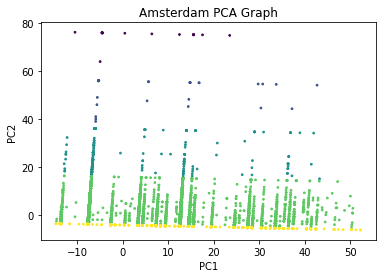

In [14]:
#PCA of Amsterdam Data
amst_pca = PCA(n_components = 2)
amst_pcs = amst_pca.fit_transform(amst_prepped)
amst_pc_df = pd.DataFrame(amst_pcs, columns = ["PC1", "PC2"])
fig = plt.scatter(amst_pc_df["PC1"], amst_pc_df["PC2"], s = 3, c = amst_star_ratings, label = amst_star_ratings)
plt.title("Amsterdam PCA Graph")
plt.xlabel("PC1")
plt.ylabel("PC2")

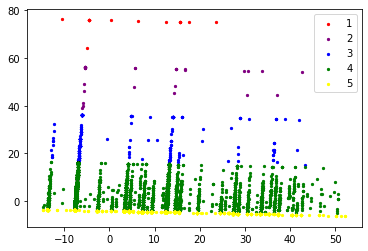

array([12.61920941, 33.92936092, -7.65736289, ..., -7.68317552,
       -7.64081219, 12.41655319])

In [15]:
import numpy as np
from matplotlib import pyplot as plt

scatter_x = amst_pc_df["PC1"].values
scatter_y = amst_pc_df["PC2"].values
group = amst_star_ratings.values
cdict = {1: 'red', 2: 'purple', 3: 'blue', 4: 'green', 5: 'yellow'}

fig, ax = plt.subplots()
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[g], label = g, s = 5)
ax.legend()
plt.show()
scatter_x

Text(0, 0.5, 'PC2')

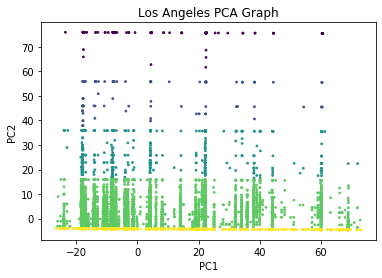

In [16]:
#PCA of Los Angeles Data
la_pca = PCA(n_components = 2)
la_pcs = la_pca.fit_transform(la_prepped)
la_pc_df = pd.DataFrame(la_pcs, columns = ["PC1", "PC2"])
fig2 = plt.scatter(la_pc_df["PC1"], la_pc_df["PC2"], s = 3, c = la_star_ratings)
plt.title("Los Angeles PCA Graph")
plt.xlabel("PC1")
plt.ylabel("PC2")

Text(0, 0.5, 'PC2')

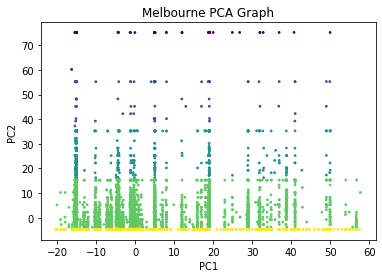

In [17]:
pca(mel_prepped, mel_star_ratings)
plt.title("Melbourne PCA Graph")
plt.xlabel("PC1")
plt.ylabel("PC2")

# KNN ALGORITHM

In [18]:
#Splitting data between features and 

#Amsterdam Data
amst_X = amst_prepped.drop("review_scores_rating", axis = 1)
amst_y = amst_star_ratings

#Los Angeles Data
la_X = la_prepped.drop("review_scores_rating", axis = 1)
la_y = la_star_ratings

#Melbourne Data
mel_X = mel_prepped.drop("review_scores_rating", axis = 1)
mel_y = mel_star_ratings

In [19]:
best_score = 0
print("K | Score")
X_train, X_test, y_train, y_test = train_test_split(amst_X, amst_y, test_size=0.33, random_state=42)
for x in range(30):
    classifier = KNN(n_neighbors = x+1).fit(X_train, y_train)
    score = classifier.score(X_test, y_test)
    if score > best_score:
        best_score = score
        print(x, " ", best_score)

K | Score
0   0.6464176951434525
2   0.661323930117006
3   0.6727039589677833
4   0.6735053694502324
5   0.6762301650905593
6   0.6845648341080302
8   0.6866485013623979


In [20]:
#5-Fold Cross Validation
amst_cv_results = cross_validate(KNN(n_neighbors = 8), amst_X, amst_y, cv = 5, return_estimator = True)
la_cv_results = cross_validate(KNN(n_neighbors = 8), la_X, la_y, cv = 5, return_estimator = True)
mel_cv_results = cross_validate(KNN(n_neighbors = 8), mel_X, mel_y, cv = 5, return_estimator = True)

In [21]:
#Printing the cross validation scores
print("Amsterdam Cross Validation Scores: ",amst_cv_results['test_score'])
print("Los Angeles Cross Validation Scores: ",la_cv_results['test_score'])
print("Melbourne Cross Validation Scores: ",mel_cv_results['test_score'])

Amsterdam Cross Validation Scores:  [0.71213323 0.69082253 0.68077228 0.65026455 0.62619048]
Los Angeles Cross Validation Scores:  [0.72352267 0.69793713 0.71225025 0.68702915 0.64089122]
Melbourne Cross Validation Scores:  [0.7489383  0.73438281 0.71607098 0.65883529 0.604     ]


In [22]:
#Choosing the best estimator
amst_classifier = amst_cv_results['estimator'][0]
la_classifier = la_cv_results['estimator'][0]
mel_classifier = mel_cv_results['estimator'][1]

In [23]:
#Reading hypothtical listing
h_listing = pd.read_csv("hypothetical_listing.csv")
h_listing = prepData(h_listing)

In [27]:
print("Amsterdam Classifier Results: \n",amst_classifier.predict(h_listing))
print("Los Angeles Classifier Results:\n",la_classifier.predict(h_listing))
print("Melbourne Classifier Results: \n", mel_classifier.predict(h_listing))

Amsterdam Classifier Results: 
 [4 4 5 4 4 4 4 5 5 4 4 4 4 5 4 4 4 5 5]
Los Angeles Classifier Results:
 [5 4 5 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5]
Melbourne Classifier Results: 
 [5 4 5 4 5 4 5 5 5 4 4 4 5 5 5 4 4 5 4]
